
# A Gentle Introduction to Permutation Feature Importance (PFI)

Permutation Feature Importance (PFI) is a method for measuring how important a given feature is to a Machine Learning model.

This tutorial gives a gentle introduction to PFI explanations of machine learning predictions, without too much technical detail.

 * PFI is a *global* explanation method - it gives an explanation for how a model behaves in *general*, rather than trying to explain specific predictions made by a model.

 * PFI is a *model-agnostic* explanation method - it can be used to explain the predictions of *any* machine learning model that takes tabular inputs and predicts outputs, rather than being limited to one type of model.




# How PFI works

PFI was originally introduced by Breiman [1]. Later, Fisher et al. generalized the method to be model-agnostic [2].

PFI gives a measure of how much a model's performance depends on each feature in a dataset.

PFI takes the model's dataset, and for each feature, it shuffles the feature's values.

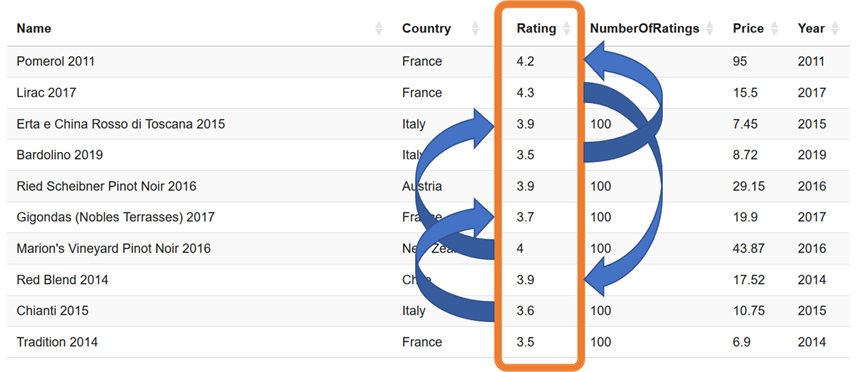

Doing this destroys any relationship between the target variable (the thing the model is trying to guess) and that feature.

After shuffling the feature values, PFI measures the performance of the model with the shuffled data. The drop in model performance is called the model's 'permutation importance' of that feature. The exact value will vary based on the random shuffling, so PFI does the shuffling many times to get an average estimate and error bars.

This process is done once for each feature to compute the model's feature importance for all the features in the dataset.


# A hands-on example - predicting red wine ratings

We will now look at an example of using PFI to explain the general behaviour of a Machine Learning model.

Below, click the 'Play' icon beside each cell to run the code step by step as you work through the example.


First, we need to install and import some software libraries. This should only take a few seconds to run.

In [ ]:

#@title Install and import software libraries
!pip install itables > /dev/null

# IO so we can read our 'CSV file' from a string
import io

# Pandas for tabular data manipulation
import pandas as pd

# Numpy for numeric processing
import numpy as np

# Matplotlib and Seaborn for pretty plots
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks')

# ITables for pretty tables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

# A simple machine learning model
from lightgbm import LGBMRegressor



## Loading a dataset

We will use a toy dataset (an extract of the Kaggle [Wine Rating and Price dataset](https://www.kaggle.com/datasets/budnyak/wine-rating-and-price)), which contains information about 100 different red wines.

Below, we load the data and print it in a table.


In [ ]:

red_wine_csv_file = """Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.0,2011
Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.5,2017
Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016
Gigondas (Nobles Terrasses) 2017,France,Gigondas,Vieux Clocher,3.7,100,19.9,2017
Marion's Vineyard Pinot Noir 2016,New Zealand,Wairarapa,Schubert,4.0,100,43.87,2016
Red Blend 2014,Chile,Itata Valley,Viña La Causa,3.9,100,17.52,2014
Chianti 2015,Italy,Chianti,Castello Montaùto,3.6,100,10.75,2015
Tradition 2014,France,Minervois,Domaine des Aires Hautes,3.5,100,6.9,2014
Chianti Riserva 2013,Italy,Chianti,Poggiotondo,3.9,100,20.95,2013
Descendant 2016,Australia,Barossa,Torbreck,4.3,100,140.64,2016
Les Obriers de la Peira Terrasses du Larzac 2017,France,Terrasses du Larzac,La Pèira en Damaisèla,4.1,100,14.52,2017
Zenas Primitivo 2018,Italy,Puglia,La Bollina,3.6,100,9.26,2018
Cuvée Confidence Côtes du Rhône Rouge 2017,France,Côtes-du-Rhône,Domaine Fond Croze,3.7,100,8.49,2017
Shiraz 2018,Australia,South Eastern Australia,Barramundi,3.2,100,6.5,2018
Proprietor's Blend 2016,South Africa,Stellenbosch,Ernie Els,4.2,100,29.09,2016
La Bienquerida 2016,Spain,Bierzo,Losada,4.3,100,41.58,2016
Cabernet Sauvignon 2015,United States,California,Hacienda,3.8,100,7.95,2015
Fulgeo Negroamaro Salento 2016,Italy,Salento,San Donaci,4.0,100,12.9,2016
Contraste Tinto 2015,Portugal,Douro,Conceito,3.4,100,9.9,2015
Steiner 2013,Hungary,Sopron,Weninger,3.7,100,24.5,2013
Old Vines Primitivo 2015,Italy,Puglia,Azienda Agricola Morella,4.2,100,38.7,2015
Virtus Tannat 2013,Brazil,Serra Gaúcha,Monte Paschoal,2.9,100,6.77,2013
Kallista 2015,South Africa,Stellenbosch,Vriesenhof,4.3,100,26.25,2015
Badia a Passignano Gran Selezione Chianti Classico 2016,Italy,Chianti Classico,Antinori,4.2,1000,39.9,2016
Saint-Émilion Grand Cru (Premier Grand Cru Classé) 2012,France,Saint-Émilion Grand Cru,Château Figeac,4.4,1000,174.49,2012
Carlo V Il Rosso dell'Imperatore 2013,Italy,Veneto,Colli Vicentini,3.7,1000,15.9,2013
Pinot Noir 2016,United States,Monterey,District 7,3.6,1001,15.98,2016
Marquis de Calon Saint-Estèphe 2015,France,Saint-Estèphe,Château Calon-Ségur,3.9,1001,43.28,2015
Hécula Monastrell 2017,Spain,Yecla,Castaño,3.3,1004,8.83,2017
Berola 2015,Spain,Campo de Borja,Borsao,3.9,1006,14.52,2015
Saint-Julien (Grand Cru Classé) 2010,France,Saint-Julien,Château Léoville Poyferré,4.4,1008,189.0,2010
Pinot Noir Bourgogne 2017,France,Bourgogne,Faiveley,3.7,1009,15.9,2017
Vigna del Noce Barbera d'Asti 2007,Italy,Barbera d'Asti,Trinchero,4.1,101,76.9,2007
I Tratturi Rosso 2017,Italy,Salento,San Marzano,3.8,101,7.04,2017
Château Pilet Bordeaux 2017,France,Bordeaux,J.Queyrens & Fils,3.6,101,6.5,2017
Sancerre Rouge 2015,France,Sancerre,Comte Lafond,4.2,101,37.34,2015
Shiraz 2016,Australia,McLaren Vale,Food Truck,3.5,101,8.67,2016
Ro-Rée Saint-Joseph 2018,France,Saint-Joseph,Louis Chèze,4.2,101,24.37,2018
Cabernet Sauvignon 2015,South Africa,Stellenbosch,Big Flower,4.0,101,16.5,2015
Cuvée Alienor Fronsac 2015,France,Fronsac,Château Mayne-Vieil,3.7,101,16.47,2015
Sabbie di Sopra al Bosco 2014,Italy,Terre del Volturno,Nanni Copé,3.8,101,31.96,2014
Roma Rosso 2018,Italy,Lazio,Poggio le Volpi,4.0,101,9.95,2018
Garnacha de Arrayán 2014,Spain,Castilla y León,Arrayán,3.7,101,21.9,2014
Cabernet Sauvignon 2018,Chile,Central Valley,Valdivieso,3.3,101,7.6,2018
Terrenus Vinhas Velhas Reserva 2013,Portugal,Alentejano,Rui Reguinga,4.1,101,27.95,2013
Fronsac 2005,France,Fronsac,Château Villars,3.8,101,25.95,2005
Cuvée Charles de Batz Madiran 2014,France,Madiran,Domaine Berthoumieu,3.7,101,14.09,2014
Stony Terrace Cabernet Sauvignon 2016,United States,Napa Valley,Rutherford Wine Company,3.8,101,18.03,2016
12 e Mezzo Puglia Primitivo Organic Wine 2016,Italy,Puglia,Varvaglione,3.9,101,9.4,2016
El Abuelo Selección Edición Limitada 2013,Spain,Almansa,Bodegas Piqueras,4.2,101,10.95,2013
Sangre de Toro Special Selection 2017,Spain,Catalunya,Torres,3.6,101,8.9,2017
Château Paul Mas Coteaux du Languedoc Clos des Mures 2018,France,Languedoc,Paul Mas,3.8,101,11.05,2018
Merlot 2018,France,Pays d'Oc,Les Jamelles,3.6,101,5.36,2018
Roscaleto Barbera d'Alba 2015,Italy,Barbera d'Alba,Enzo Boglietti,3.9,101,31.18,2015
Barolo Cannubi 2014,Italy,Barolo,Giacomo Fenocchio,4.0,101,39.9,2014
Pauillac (Premier Grand Cru Classé) 2017,France,Pauillac,Château Mouton Rothschild,4.6,101,633.62,2017
Cabernet Sauvignon 2014,United States,Washington,Stimson Estate Cellars,3.3,101,8.29,2014
Côte-Rôtie Le Gallet Blanc 2017,France,Côte-Rôtie,Francois Villard,4.4,101,48.0,2017
Capatosta 2015,Italy,Toscana,Poggio Argentiera,3.8,101,19.9,2015
Constance Madiran 2015,France,Madiran,Domaine Berthoumieu,3.8,101,9.5,2015
Oak Cask Malbec 2019,Argentina,Mendoza,Trapiche,3.7,1010,7.36,2019
Amancaya Malbec - Cabernet Sauvignon 2017,Argentina,Mendoza,Caro (Catena and Rothschild),4.0,1010,16.8,2017
Laccento Ruché di Castagnole Monferrato 2017,Italy,Ruchè,Montalbera,4.0,1012,19.9,2017
San Leonardo 2011,Italy,Vigneti delle Dolomiti,San Leonardo,4.3,1012,48.64,2011
Fausto Tannat 2015,Brazil,Serra Gaúcha,Pizzato,3.6,1012,11.35,2015
Pauillac (Grand Cru Classé) 2007,France,Pauillac,Château Pichon Baron,4.4,1014,119.0,2007
Disciples 2016,United States,Napa Valley,The Crane Assembly,4.3,1014,53.61,2016
Zinfandel 2015,United States,Mendocino County,Bonterra,3.6,1015,16.75,2015
Margaux 2010,France,Margaux,Château Labégorce,4.0,1016,40.95,2010
La Luna e i Falò Barbera d'Asti Superiore 2015,Italy,Barbera d'Asti,Vite Colte,3.8,1016,11.49,2015
Ribera del Duero 2015,Spain,Ribera del Duero,Garmón,4.2,1017,38.8,2015
Les Jardins Rouge 2018,France,Faugères,Saint Antonin,3.8,102,7.95,2018
Nero d'Avola - Syrah 2018,Italy,Terre Siciliane,Roccaperciata,3.7,102,4.75,2018
La Bienquerida 2013,Spain,Bierzo,Losada,4.1,102,35.97,2013
Bonera 2018,Italy,Terre Siciliane,Mandrarossa,3.7,102,9.5,2018
Noi 4 Bolgheri 2016,Italy,Bolgheri,Tenuta dei Sette Cieli,4.0,102,23.5,2016
Pinot Noir 2016,New Zealand,Marlborough,Clos Henri Vineyard,3.9,102,27.78,2016
Saint-Émilion Grand Cru 2005,France,Saint-Émilion Grand Cru,Château Grand Barrail Lamarzelle Figeac,3.9,102,39.95,2005
Gran Selección Tempranillo 2017,Spain,Castilla,Viña San Juan,3.4,102,6.75,2017
Syrah 2017,South Africa,Paarl,Glen Carlou,3.9,102,18.25,2017
Zweigelt 2017,Austria,Burgenland,Judith Beck,3.9,102,10.6,2017
Saint-Émilion Grand Cru 2015,France,Saint-Émilion Grand Cru,Château Vieux Clos St. Emilion,4.1,102,23.09,2015
Listán Negro 2017,Spain,Lanzarote,Bermejo,3.6,102,17.95,2017
Viile Metamorfosis Merlot 2015,Romania,Dealu Mare,Vitis Metamorfosis,3.5,102,7.5,2015
Merlot - Cabernet Sauvignon - Petit Verdot 2014,South Africa,Walker Bay,Creation,3.9,102,12.48,2014
RWT Shiraz 2017,Australia,Barossa Valley,Penfolds,4.4,102,229.0,2017
Fronton 2018,France,Fronton,Château Bellevue La Forét,3.5,102,6.95,2018
Costers Del Gravet Montsant 2013,Spain,Montsant,Capçanes,3.7,102,13.95,2013
Merlot 2018,Italy,Terre Siciliane,Cusumano,3.4,102,7.9,2018
Pinot Noir 2015,Austria,Burgenland,Paul Achs,3.7,102,33.05,2015
Coume de l'Olla Rouge 2019,France,Vin de France,Matassa,4.1,102,16.96,2019
Schwarzer 2017,Germany,Pfalz,Weingut Metzger,3.6,102,13.15,2017
Haut-Médoc 2015,France,Haut-Médoc,Château Beaumont,3.8,1020,17.36,2015
Bourgogne Pinot Noir (La Vignée) 2015,France,Bourgogne,Bouchard Père & Fils,3.6,1020,17.59,2015
Pinot Noir 2017,South Africa,Hemel-en-Aarde Valley,Hamilton Russell Vineyards,4.2,1022,49.09,2017
Zinfandel 2016,United States,California,Geyser Peak,3.7,1023,10.9,2016
Valpolicella Ripasso Classico Superiore 2017,Italy,Valpolicella Ripasso Classico,Bolla,3.7,1024,15.5,2017
Rosso di Montalcino 2015,Italy,Rosso di Montalcino,Castiglion del Bosco,3.9,1025,26.5,2015"""

# Read the data
dataframe = pd.read_csv(io.StringIO(red_wine_csv_file))

dataframe


Name        Country  \
0                                   Pomerol 2011         France   
1                                     Lirac 2017         France   
2             Erta e China Rosso di Toscana 2015          Italy   
3                                 Bardolino 2019          Italy   
4                 Ried Scheibner Pinot Noir 2016        Austria   
..                                           ...            ...   
95         Bourgogne Pinot Noir (La Vignée) 2015         France   
96                               Pinot Noir 2017   South Africa   
97                                Zinfandel 2016  United States   
98  Valpolicella Ripasso Classico Superiore 2017          Italy   
99                      Rosso di Montalcino 2015          Italy   

                           Region                      Winery  Rating  \
0                         Pomerol       Château La Providence     4.2   
1                           Lirac          Château Mont-Redon     4.3   
2                         Toscana                  Renzo Masi     3.9   
3                       Bardolino                  Cavalchina     3.5   
4                       Carnuntum                 Markowitsch     3.9   
..                            ...                         ...     ...   
95                      Bourgogne        Bouchard Père & Fils     3.6   
96          Hemel-en-Aarde Valley  Hamilton Russell Vineyards     4.2   
97                     California                 Geyser Peak     3.7   
98  Valpolicella Ripasso Classico                       Bolla     3.7   
99            Rosso di Montalcino        Castiglion del Bosco     3.9   

    NumberOfRatings  Price  Year  
0               100  95.00  2011  
1               100  15.50  2017  
2               100   7.45  2015  
3               100   8.72  2019  
4               100  29.15  2016  
..              ...    ...   ...  
95             1020  17.59  2015  
96             1022  49.09  2017  
97             1023  10.90  2016  
98             1024  15.50  2017  
99             1025  26.50  2015  

[100 rows x 8 columns]

For each wine, you can see that we have the following data;

 * The name of the vintage
 * The country of origin, region and winery,
 * A 'star rating' for the wine, ranging from 0-5
 * How many ratings that vintage has
 * The price per bottle, and
 * The year of that vintage



## Training a model to predict wine ratings

We train a model to predict the star rating of a wine from the price, year, and number of ratings.

In [ ]:

# We will focus on the numeric 'Price', 'Year', and 'Number of Ratings' features

X = dataframe[['Price', 'Year', 'NumberOfRatings']]
X = X.apply(pd.to_numeric)

# We will try and predict the star rating of this type of wine (ranges from 0 to 5)
y = dataframe.Rating



Below, we train a simple machine learning model (called a 'light gradient-boosting machine') to predict wine ratings from price, year, and number of ratings. This should only take a few seconds to do.


In [ ]:

# Create and fit a machine learning model to predict rating from price, year and number of ratings
model = LGBMRegressor()
model.fit(X, y)


LGBMRegressor()


We can visualise the model's predictions (vs. the true ratings) to see how well it predicts wine ratings.


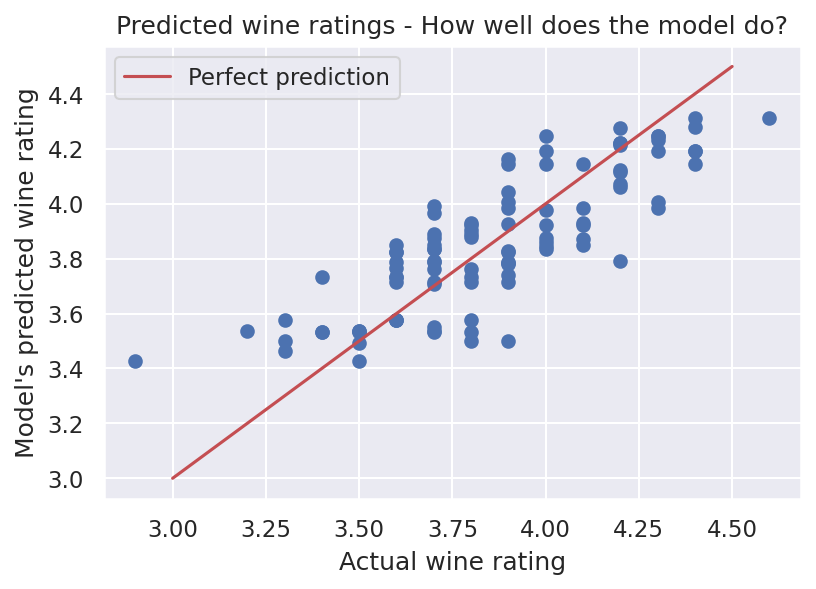

In [ ]:

# Predict the scores for each of our wines
y_hat = model.predict(X)

# Visualise the model's predictions
sns.set()
plt.figure(figsize=(6, 4), dpi=150)

plt.scatter(y, y_hat)
plt.plot([3., 4.5], [3., 4.5], 'r-', label='Perfect prediction')

plt.legend()
plt.title("Predicted wine ratings - How well does the model do?")
plt.xlabel("Actual wine rating")
plt.ylabel("Model's predicted wine rating")

plt.show()



Every blue dot is one wine from the dataset. Dots above the red line indicate that the model guessed higher than the actual star rating. Dots below the red line indicate that the model guessed lower than the actual star rating.

Looking at this plot doesn't tell us much about how our model is making it's predictions. Let's use PFI to try and understand what the model is doing!



## Explaining the model's behaviour

We call the `permutation_importance` function to compute the permutation importance for each feature in our dataset.

The argument `n_repeats=30` is how many random shuffles we want to do for each feature.

We plot the results in a box-plot.

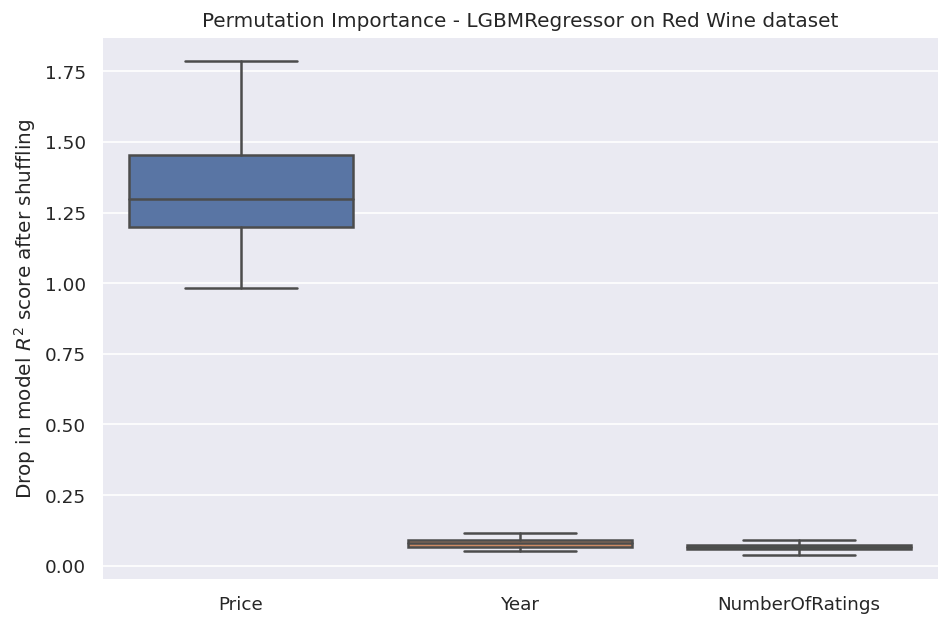

In [ ]:

# Import the PFI function from the scikit-learn Machine Learning library
from sklearn.inspection import permutation_importance

pfi_values = permutation_importance(
    model,
    X,
    y,
    n_repeats=30
)

results = pd.DataFrame(data=pfi_values['importances'].T, columns=X.columns)

plt.figure(figsize=(9, 6), dpi=120)
sns.boxplot(data=results)
plt.title(f"Permutation Importance - {str(model)[:-2]} on Red Wine dataset")
plt.ylabel(f"Drop in model $R^2$ score after shuffling")
plt.show()



The plot indicates that our regression model depends most on a wine's *Price* feature when predicting it's star rating.

The wine's *Year* and *NumberOfRatings* features also have a small effect, but it is fairly negligible, and the difference in effect between *Year* and *NumberOfRatings* can't be statistically distinguished (because their error bars overlap).

If we wanted to, we could also use statistical tests to see if the permutation importance for *Year* and *NumberOfRatings* are significant or not.



# Pause and ponder

 * Do the PFI 'explanations' align with your understanding of how Red wine vintages are rated by wine connisuers?

 * Are PFI 'explanations' useful for understanding the model's behaviour? What about for explaining how the model works?

 * What kind of stakeholders are PFI explanations best suited for?



# Some more detail

PFI explanations depend on the *model*, on a specific *performance metric*, and on the *data*.

So in our case, we had a Light Gradient Boosting Machine regression model. The default performance metric for this type of model is the coefficient of determination ($R^2$ value). The dataset we used is the Red Wine ratings dataset.

If we used a different performance metric, a different dataset, or a different model, the PFI values we calculate would be different and not necessarily comparable. We can make PFI values somewhat more comparable across these variations by using error ratios (a percentage change in performance) instead of the absolute change in performance.

One big limitation of PFI is that it only works for numeric, tabular features. Lots of machine learning models use other types of data (such as Audio, Images, Text etc.) - PFI cannot be used with these types of data.

Another big drawback of PFI values is that the methodology assumes that every feature is independent. If two features are correlated, then the PFI values could be bogus. The shuffling can also produce unlikely or impossible data points - for instance a 5-star rated wine that only costs $2 a bottle. This can have important implications for the generalisation abilit of the model.

Extension activity: read sections [8.5.4 and 8.5.5 'Advantages and Disadvantages of PFI explanations'](https://christophm.github.io/interpretable-ml-book/feature-importance.html#advantages-9) from the Interpretable Machine Learning Book and reflect on what the means for when and where you might use PFI explanations.


# References

[1] Breiman, Leo.“Random Forests.” Machine Learning 45 (1). Springer: 5-32 (2001).

[2] Fisher, Aaron, Cynthia Rudin, and Francesca Dominici. “All models are wrong, but many are useful: Learning a variable’s importance by studying an entire class of prediction models simultaneously.” http://arxiv.org/abs/1801.01489 (2018).

---

This tutorial is adapted from content at [scikit-learn](https://scikit-learn.org/stable/modules/permutation_importance.html), and [Christoph M's Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/feature-importance.html).